<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista10 - BERT
**Nome: Augusto Cesar de Camargo** 

**Numero Usp: 11823558** 









______________




O objetivo desta lista é fazer com que vocês se familiarizem com o BERT por meio da biblioteca HuggingFace. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [1]:
!nvidia-smi

Sun Nov 08 12:29:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.38       Driver Version: 456.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    12W /  N/A |    164MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments,
)
from sklearn.model_selection import train_test_split

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [3]:
b2wCorpus = pd.read_csv("../Semana 03/data/B2W-Reviews01.csv",";",usecols=['review_text','recommend_to_a_friend'], encoding='utf-8')
for i, row in b2wCorpus.iterrows():
    ifor_val = row['review_text'].lower()
    b2wCorpus.at[i,'review_text']= ifor_val
b2wCorpus.head()

,recommend_to_a_friend,review_text
0,Yes,estou contente com a compra entrega rápida o ú...
1,Yes,"por apenas r$1994.20,eu consegui comprar esse ..."
2,Yes,supera em agilidade e praticidade outras panel...
3,Yes,meu filho amou! parece de verdade com tantos d...
4,Yes,"a entrega foi no prazo, as americanas estão de..."


In [4]:
b2wCorpus["review_text"]

0         estou contente com a compra entrega rápida o ú...
1         por apenas r$1994.20,eu consegui comprar esse ...
2         supera em agilidade e praticidade outras panel...
3         meu filho amou! parece de verdade com tantos d...
4         a entrega foi no prazo, as americanas estão de...
                                ...                        
132368    vale muito, estou usando no controle do xbox e...
132369    prático e barato, super indico o produto para ...
132370    chegou antes do prazo previsto e corresponde a...
132371    material fraco, poderia ser melhor. ficou deve...
132372    comprei esse produto, quando chegou estava com...
Name: review_text, Length: 132373, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [5]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if str(word).lower() == 'yes' else 0)
x = b2wCorpus['review_text'].values.astype('str')
y = b2wCorpus['recommend_to_a_friend'].values

### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### Tokenizando

Para aplicar o processo de _Tokenize_ dos nossos dados, diferente das listas anteriores, utilizaremos a classe [BertTokenizer](https://huggingface.co/transformers/master/model_doc/bert.html#berttokenizer) da biblioteca [transformers](https://github.com/huggingface/transformers) do HuggingFace.

Para isso, veja o exemplo abaixo:


In [7]:
#REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
#tokenizer = BertTokenizer.from_pretrained(REF_MODEL)
#text = pd.DataFrame(["isso é um text", "o rato roeu a roupa", "do rei de Roma"])

In [8]:
#SEQ_LEN=5
#encoded_text = tokenizer(
#    text.values.tolist(),
#    text_pair=None,
#    is_split_into_words=True,
#    padding="max_length",
#    truncation=True,
#    max_length=SEQ_LEN,
#    pad_to_max_length=True,
#    return_tensors='tf'
#)
#encoded_text_labels = np.array([0,0,1])

In [9]:
#encoded_text

Como é possível ver, o resultado gera um dicionário com 3 chaves, representando diferentes tensores:

    - input_ids (os arrays de entrada convertidos para inteiro)
    - token_type_ids (Indicação se pertence a sentença A ou B [0 é sentença A e 1 é sentença B])
    - attention_mask (indicando quais tokens foram mascarados. Como todos os tokens **não** foram mascarados, o valor aqui sempre é 1)

## <font color='blue'>Questão 3 </font>

Aplique o tokenizer nos dados de treino e teste, gerando duas variáveis **encoded_train** e **encoded_test**, considerando o max_length como o tamanho da sentença ideal. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

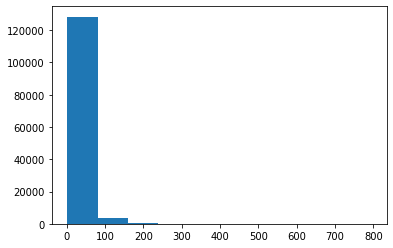

In [10]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [11]:
#REF_MODEL = "bert-base-multilingual-cased"
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(REF_MODEL)

In [12]:
SEQUENCE_MAXLEN = 50

encoded_train = tokenizer(
    [[line] for line in x_train],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)
print(encoded_train)

{'input_ids': array([[ 101, 2080, 1075, ...,    0,    0,    0],
       [ 101, 4171, 3575, ...,    0,    0,    0],
       [ 101, 3576,  785, ..., 3506,  119,  102],
       ...,
       [ 101, 1941, 1021, ...,    0,    0,    0],
       [ 101, 3576, 2281, ...,    0,    0,    0],
       [ 101,  122,  785, ...,    0,    0,    0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


In [13]:
encoded_valid = tokenizer(
   [[line] for line in x_val],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)

In [14]:
encoded_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
encoded_train['input_ids'].shape

(92661, 50)

### Montando o modelo

Para montar o modelo, iremos utilizar a classe TFBertForSequenceClassification, do HuggingFace

Aqui tem um exemplo de código para vocês seguirem!


In [16]:
#bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
#input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_token', dtype='int32')
#input_masks_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='masked_token', dtype='int32')#

#X = bert_model(input_ids, input_masks_ids)

In [17]:
#model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
#model.summary()

In [18]:
#opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
#my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
#model.compile(opt, "sparse_categorical_crossentropy", metrics=["acc"])

In [19]:
#history = model.fit(
#    [encoded_text["input_ids"], encoded_text["attention_mask"]],
#    encoded_text_labels,
#    batch_size=32,
#    epochs=2,
#    callbacks=my_callbacks,
#)

## Treinando e avaliando seu modelo

###  <font color='blue'>Questão 4 </font>

Defina e treine seu modelo.

**Lembre-se de tambem adicionar os dados de validação do modelo**

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
with tf.device('GPU:0'):
    bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
    input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')

    X = bert_model(input_ids, input_masks_ids)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
    my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    #opt = tf.keras.optimizers.Adam(learning_rate=0.3)
    opt=tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")
    model.compile(opt, loss=loss, metrics=metrics)
    history = model.fit(
        [encoded_train["input_ids"],
         encoded_train["attention_mask"]],
        y_train,
        batch_size=32,
        epochs=5,
        callbacks=my_callbacks,
        validation_data = ([encoded_valid["input_ids"],
                           encoded_valid["attention_mask"]],
                           y_val)
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the P

Epoch 1/5
2896/2896 [==============================] - 3111s 1s/step - loss: 0.6027 - accuracy: 0.7203 - val_loss: 0.5867 - val_accuracy: 0.7287
Epoch 2/5
2896/2896 [==============================] - 1077s 372ms/step - loss: 0.5881 - accuracy: 0.7275 - val_loss: 0.5855 - val_accuracy: 0.7287
Epoch 3/5
2760/2896 [===========================>..] - ETA: 45s - loss: 0.5879 - accuracy: 0.7276